In [1]:
import numpy as np
import joblib
import os
import pandas as pd

# 使用网格搜索方法来进行参数选择
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from collections import Counter
# 使用StratifiedShuffleSplit类进行分层抽样
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from data_process.light_curve import ASASLightCurve

# 使用StratifiedShuffleSplit类进行分层抽样
from sklearn.model_selection import train_test_split

In [2]:
demo_EB = np.load("../dataset/light_curve_instance/eclipsing_binary/demo_EB.npy",
                                allow_pickle=True)
demo_EB

array([<EBLightCurve length=184>
               time          flux  flux_err

               Time        float64 float64
       ------------------- ------- --------
       -1.3369541998218037  13.454  0.02185
       -1.2925687000298909    13.4  0.02188
        -1.266277799939461  13.381   0.0219
       -1.2604840998238347  13.368  0.02191
       -1.2560777000672947  13.375   0.0219
        -1.206585100225419  13.311  0.02202
       -1.1986572998689609  13.296  0.02206
       -1.1977387999824167  13.321    0.022
       -1.1781070001464211  13.313  0.02202
                       ...     ...      ...
        1.2184728001465361  13.331  0.02198
        1.2354908000723321  13.399  0.02188
         1.243537200071612  13.294  0.02206
         1.245296399772045  13.357  0.02193
        1.2463833998270357  13.413  0.02186
        1.2523397999200072  13.391  0.02188
         1.263188100068724  13.391  0.02188
         1.281747100188829  13.426  0.02186
        1.2917282001824748  13.388  0.02189

In [3]:
from matplotlib import pyplot as plt

EA, EB, EW,ELL = None, None, None,None

for lc in demo_EB:
    if EA and EB and EW and ELL:
        break
    if lc.meta["class_probability"] > 0.8:
        if lc.meta["variable_type"] == "EA":
            EA = lc
        elif lc.meta["variable_type"] == "EB":
            EB = lc
        elif lc.meta["variable_type"] == "EW":
            EW = lc
        elif lc.meta["variable_type"] == "ELL":
            ELL = lc
    else:
        continue

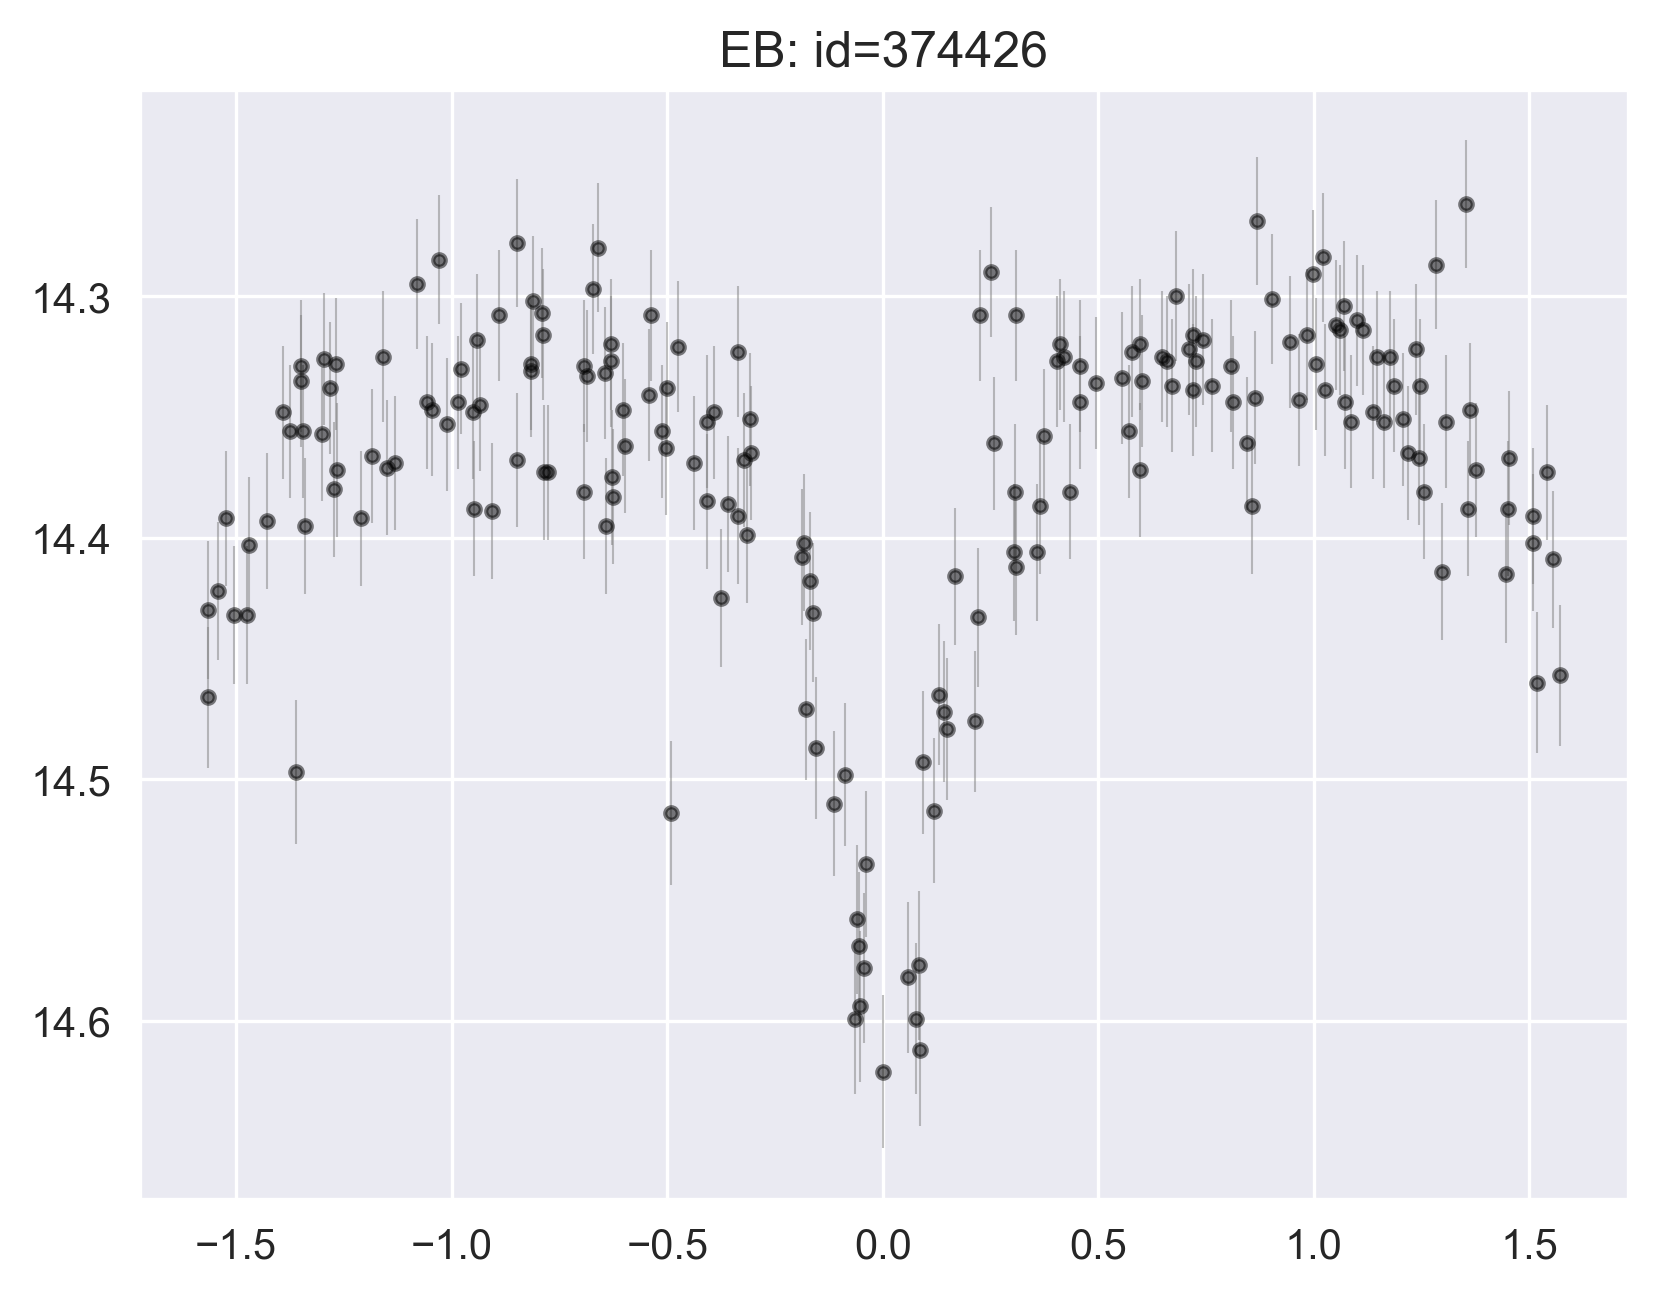

In [10]:
lc = EB
time = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value
period = lc.meta["period"]

fig,ax = plt.subplots(dpi=300)
plt.errorbar(time, flux, yerr=flux_err, fmt='.', ecolor='gray', color='black', elinewidth=0.5, capsize=0,alpha=0.5)
ax.invert_yaxis()
plt.title(lc.meta["variable_type"]+": id="+ lc.meta["source_id"])
plt.show()

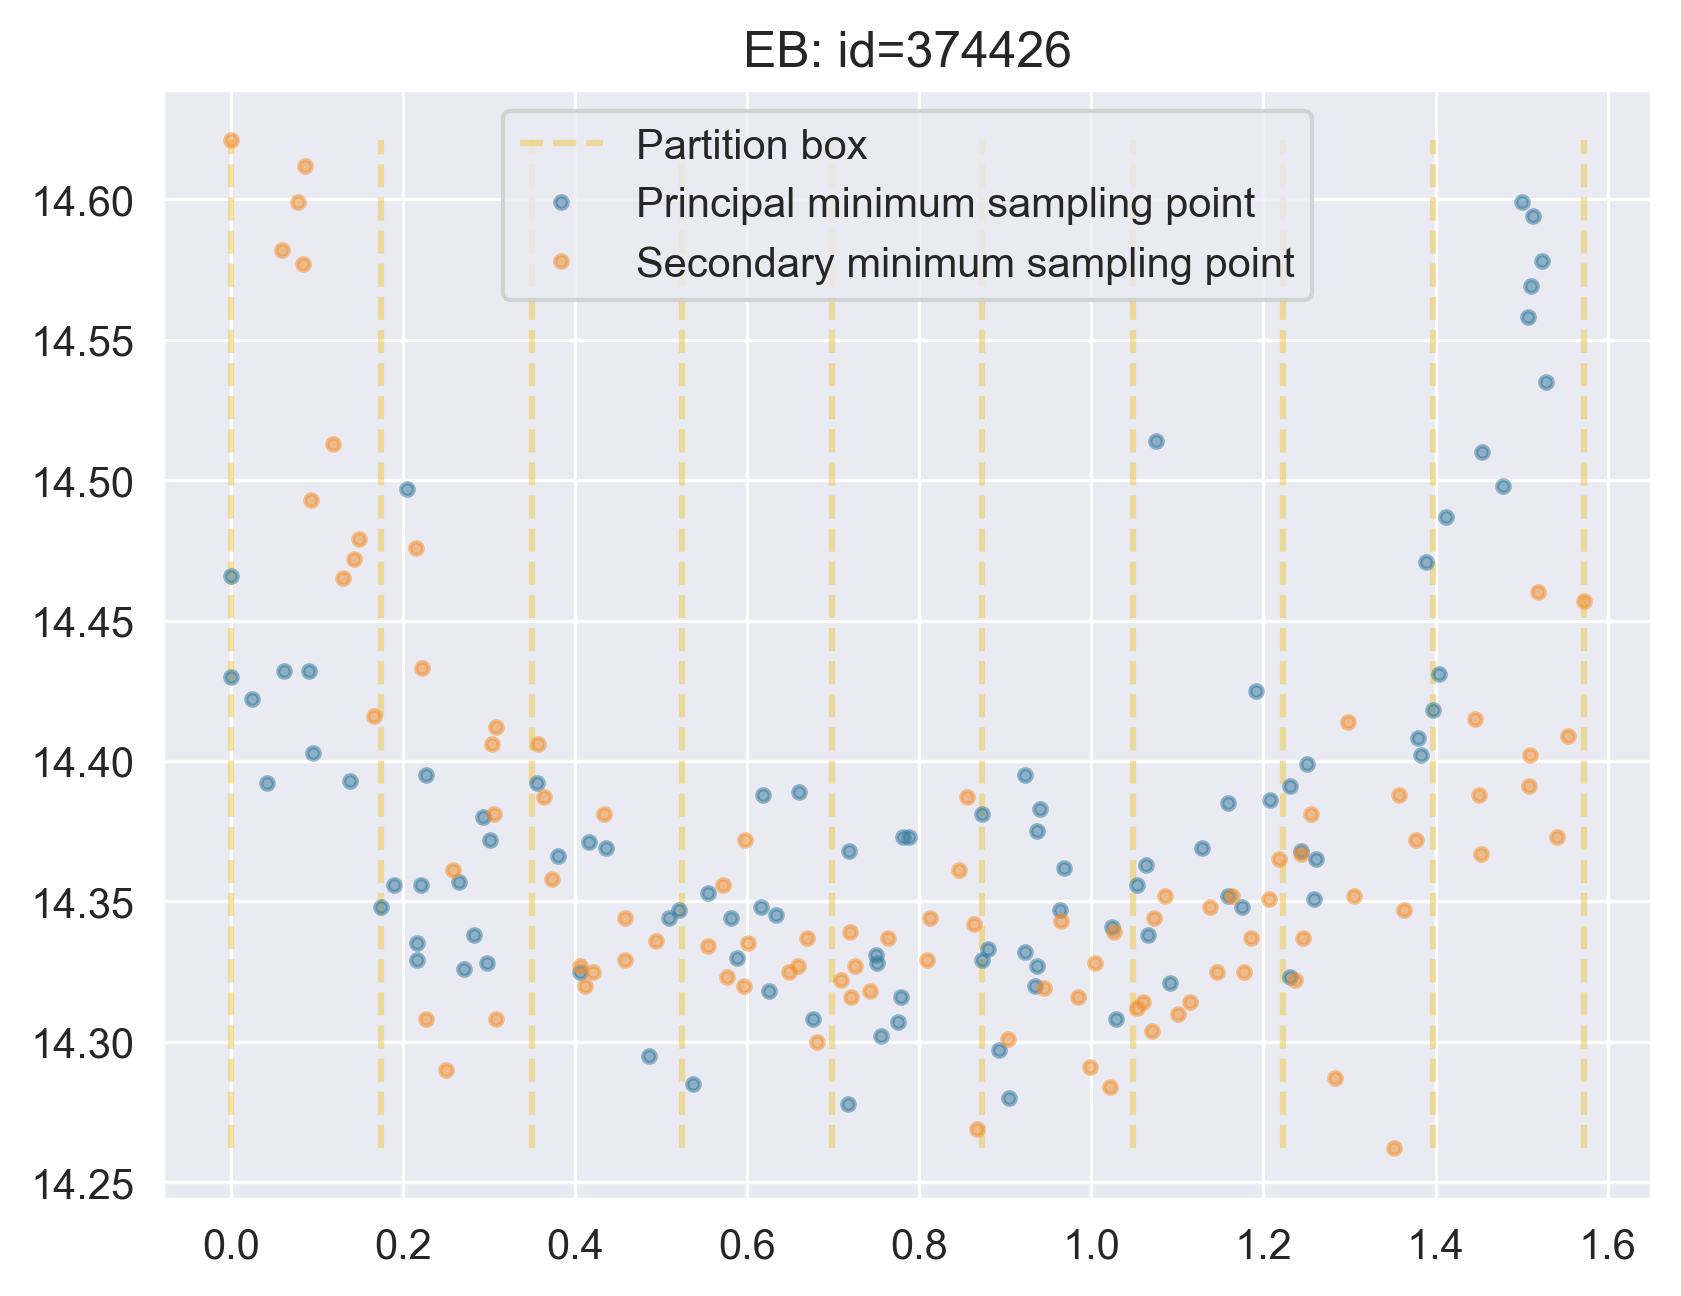

In [59]:
from data_process.get_add_features import get_greater_peak_coordination, split_light_curve_to_left_right

greater_value_time, greater_flux = get_greater_peak_coordination(time, flux)
left_t, left_y, right_t, right_y = split_light_curve_to_left_right(time, flux, greater_value_time)
left_t = left_t- min(left_t)
right_t = right_t - min(right_t)

min_mag = min(flux)
max_mag = max(flux)
min_t = 0.
max_t = max(left_t[-1], right_t[-1])

bin_num = 10
bins = np.linspace(min_t,max_t,bin_num,endpoint=True)
plt.figure(dpi=300)
plt.vlines(bins, min_mag, max_mag, linestyles='dashed', colors='#edc948',alpha=0.5,label='Partition box')
plt.plot(left_t, left_y, '.', color='#32779b', alpha=0.5,label='Principal minimum sampling point')
plt.plot(right_t, right_y, '.', color='#f28e2b', alpha=0.5,label='Secondary minimum sampling point')
plt.title(lc.meta["variable_type"]+": id="+ lc.meta["source_id"])
plt.legend()

plt.show()

In [60]:
bins[0],bins[1]

(0.0, 0.17467834446489253)

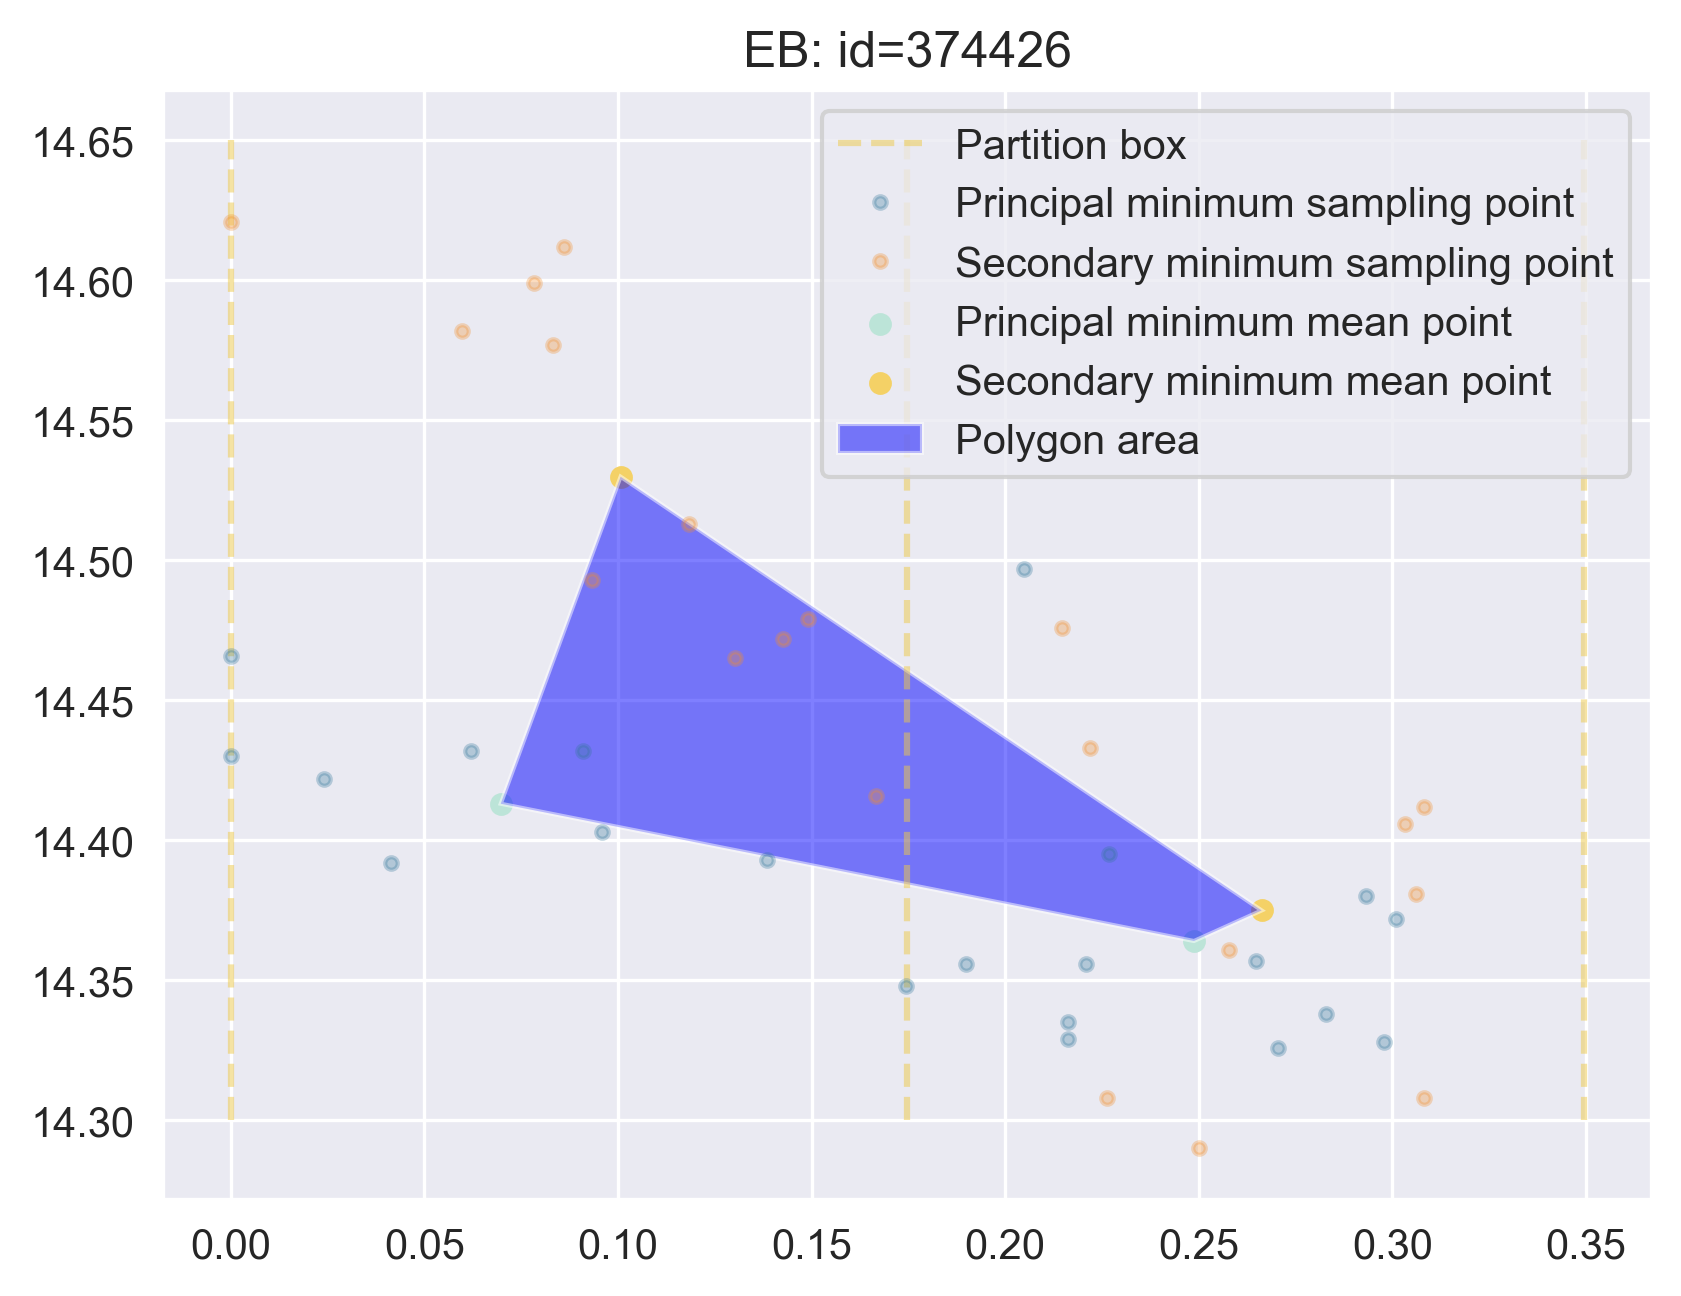

In [61]:
left_t_idx1 = np.argwhere((left_t>=bins[0]) & (left_t<bins[1])).flatten()
right_t_idx1 = np.argwhere((right_t>=bins[0]) & (right_t<bins[1])).flatten()

left_t_n1 = left_t[left_t_idx1]
left_y_n1 = left_y[left_t_idx1]
right_t_n1 = right_t[right_t_idx1]
right_y_n1 = right_y[right_t_idx1]

left_t_idx2 = np.argwhere((left_t>=bins[1]) & (left_t<bins[2])).flatten()
right_t_idx2 = np.argwhere((right_t>=bins[1]) & (right_t<bins[2])).flatten()

left_t_n2 = left_t[left_t_idx2]
left_y_n2 = left_y[left_t_idx2]
right_t_n2 = right_t[right_t_idx2]
right_y_n2 = right_y[right_t_idx2]

t_l1_mean = np.mean(left_t_n1)
t_l2_mean = np.mean(left_t_n2)
y_l1_mean = np.mean(left_y_n1)
y_l2_mean = np.mean(left_y_n2)

t_r1_mean = np.mean(right_t_n1)
t_r2_mean = np.mean(right_t_n2)
y_r1_mean = np.mean(right_y_n1)
y_r2_mean = np.mean(right_y_n2)


plt.figure(dpi=300)
plt.vlines(np.linspace(0.0,bins[2],3,endpoint=True), 14.30, 14.65, linestyles='dashed', colors='#edc948',alpha=0.5,label='Partition box')
plt.plot(left_t_n1, left_y_n1, '.', color='#32779b', alpha=0.3,label='Principal minimum sampling point')
plt.plot(right_t_n1, right_y_n1, '.', color='#f28e2b', alpha=0.3,label='Secondary minimum sampling point')
plt.plot(left_t_n2, left_y_n2, '.', color='#32779b', alpha=0.3)
plt.plot(right_t_n2, right_y_n2, '.', color='#f28e2b', alpha=0.3)

plt.scatter(t_l1_mean, y_l1_mean, marker='o', color='#bce4d8', s=20, label='Principal minimum mean point')
plt.scatter(t_l2_mean, y_l2_mean, marker='o', color='#bce4d8', s=20)

plt.scatter(t_r1_mean, y_r1_mean, marker='o', color='#f4d166', s=20, label='Secondary minimum mean point')
plt.scatter(t_r2_mean, y_r2_mean, marker='o', color='#f4d166', s=20)

a1 = [t_l1_mean, t_l2_mean, t_r2_mean, t_r1_mean]
a2 = [y_l1_mean, y_l2_mean, y_r2_mean, y_r1_mean]
plt.fill(a1, a2, "b",alpha=0.5, label='Polygon area')
plt.title(lc.meta["variable_type"]+": id="+ lc.meta["source_id"])

plt.legend()

plt.show()